Enter the pixel scale (in nanometers per pixel):  2.984
Enter crop coordinates (x_start, y_start, x_end, y_end) or press Enter to skip:  1,1,1024,690


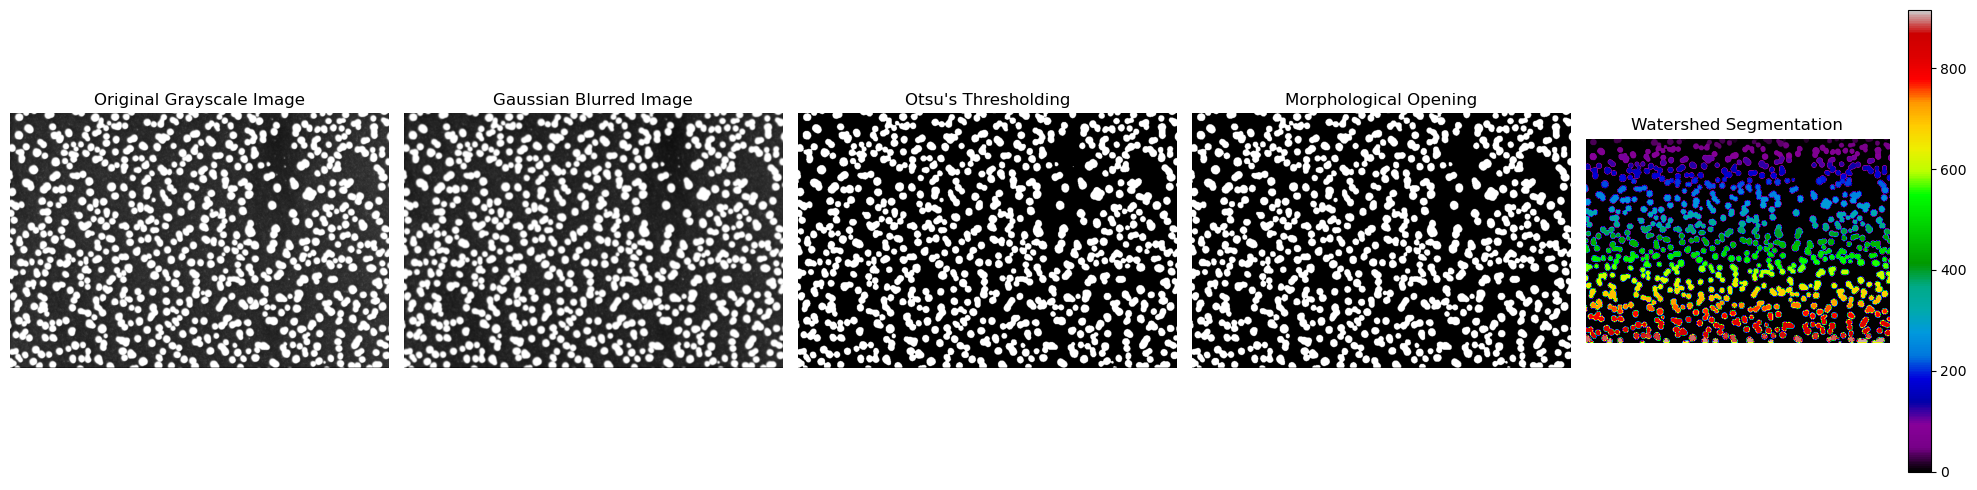

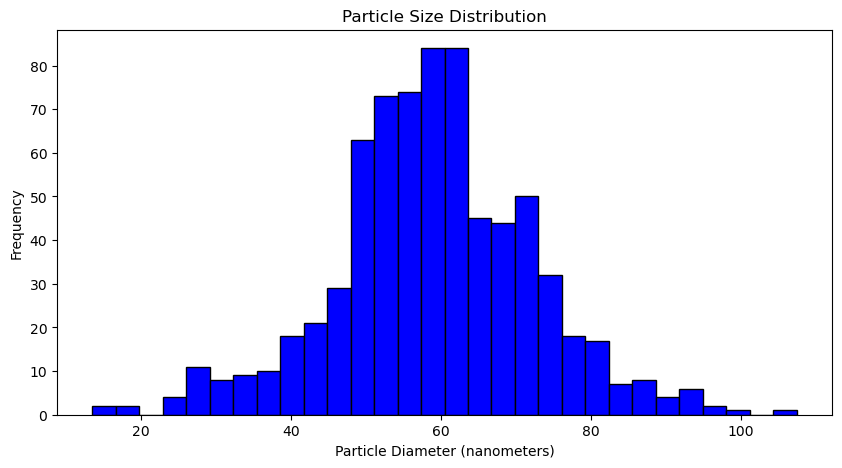

Number of Particles: 727
Particle Density: 115.8356 particles per µm²
Average Particle Size: 58.97 nm
Standard Deviation of Particle Size: 13.35 nm


In [3]:
import numpy as np
from skimage import io, color, filters, morphology, measure, segmentation
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

def analyze_particles(image_path, pixel_scale_nm_per_pixel, crop_coords=None):
    """
    Analyze particles in an image and display results.
    
    Parameters:
    - image_path (str): Path to the image file.
    - pixel_scale_nm_per_pixel (float): Scale factor for converting pixel measurements to nanometers.
    - crop_coords (tuple): Coordinates to crop the image (x_start, y_start, x_end, y_end).
    """
    # Convert nanometers to micrometers
    pixel_scale_um_per_pixel = pixel_scale_nm_per_pixel / 1000.0
    
    # Load the image
    try:
        image = io.imread(image_path)
    except FileNotFoundError:
        print(f"File {image_path} not found.")
        return
    except Exception as e:
        print(f"An error occurred: {e}")
        return
    
    # Crop the image if crop coordinates are provided
    if crop_coords:
        x_start, y_start, x_end, y_end = crop_coords
        image = image[y_start:y_end, x_start:x_end]
    
    # Convert to grayscale if the image is not already
    if len(image.shape) == 3:
        gray_image = color.rgb2gray(image)
    else:
        gray_image = image
    
    # Apply Gaussian blur to reduce noise
    sigma = 1.0
    blurred_image = filters.gaussian(gray_image, sigma=sigma)
    
    # Apply Otsu's thresholding
    thresh_val = filters.threshold_otsu(blurred_image)
    binary_image = blurred_image > thresh_val
    
    # Apply morphological opening to clean up the binary image
    morph_element_size = 3
    cleaned_image = morphology.opening(binary_image, morphology.square(morph_element_size))
    
    # Compute the distance transform
    distance = ndi.distance_transform_edt(cleaned_image)
    
    # Identify local maxima for the watershed algorithm
    max_filter_size = 20
    local_maxi = ndi.label(ndi.maximum_filter(distance, size=max_filter_size) == distance)[0]
    
    # Apply the watershed algorithm
    labels = segmentation.watershed(-distance, local_maxi, mask=cleaned_image)
    
    # Label the connected components in the watershed segmented image
    labeled_particles = measure.label(labels)
    
    # Measure properties of each labeled region
    properties = measure.regionprops(labeled_particles)
    
    # Extract the area of each particle in pixels and convert to nanometers squared
    particle_areas_pixels = [prop.area for prop in properties]
    particle_areas_nm2 = [area * pixel_scale_nm_per_pixel**2 for area in particle_areas_pixels]
    
    # Calculate equivalent diameter in nanometers (d = sqrt(4 * area / pi))
    particle_diameters_nm = [np.sqrt(4 * area / np.pi) for area in particle_areas_nm2]
    
    # Calculate the total number of particles
    num_particles = len(particle_diameters_nm)
    
    # Calculate the total area of the image in pixels and convert to micrometers squared
    total_area_pixels = gray_image.shape[0] * gray_image.shape[1]
    total_area_um2 = total_area_pixels * pixel_scale_um_per_pixel**2
    
    # Calculate particle density (number of particles per unit area in µm²)
    particle_density = num_particles / total_area_um2
    
    # Calculate average particle size and standard deviation
    avg_particle_size_nm = np.mean(particle_diameters_nm)
    std_particle_size_nm = np.std(particle_diameters_nm)
    
    # Plot the intermediate results
    fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharex=True, sharey=True)
    ax = axes.ravel()
    
    ax[0].imshow(gray_image, cmap='gray')
    ax[0].set_title('Original Grayscale Image')
    ax[0].axis('off')
    
    ax[1].imshow(blurred_image, cmap='gray')
    ax[1].set_title('Gaussian Blurred Image')
    ax[1].axis('off')
    
    ax[2].imshow(binary_image, cmap='gray')
    ax[2].set_title("Otsu's Thresholding")
    ax[2].axis('off')
    
    ax[3].imshow(cleaned_image, cmap='gray')
    ax[3].set_title('Morphological Opening')
    ax[3].axis('off')
    
    im = ax[4].imshow(labels, cmap='nipy_spectral')
    plt.colorbar(im, ax=ax[4])
    ax[4].set_title('Watershed Segmentation')
    ax[4].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Plot histogram of particle sizes (diameters) in nanometers
    plt.figure(figsize=(10, 5))
    plt.hist(particle_diameters_nm, bins=30, color='blue', edgecolor='black')
    plt.title('Particle Size Distribution')
    plt.xlabel('Particle Diameter (nanometers)')
    plt.ylabel('Frequency')
    plt.show()
    
    # Display results
    print(f'Number of Particles: {num_particles}')
    print(f'Particle Density: {particle_density:.4f} particles per µm²')
    print(f'Average Particle Size: {avg_particle_size_nm:.2f} nm')
    print(f'Standard Deviation of Particle Size: {std_particle_size_nm:.2f} nm')

# Path to the image file
image_path = '/Users/divyansh/Documents/PhD/4th Semester/Particle detection/Particle detection_3/easy_nanoparticle_detector-main/LED-DG008-0-AuNPs_02.tif'

# Get pixel scale from the user (in nanometers per pixel)
pixel_scale_nm_per_pixel = float(input("Enter the pixel scale (in nanometers per pixel): "))

# Get crop coordinates from the user (if any)
crop_input = input("Enter crop coordinates (x_start, y_start, x_end, y_end) or press Enter to skip: ")
if crop_input:
    crop_coords = tuple(map(int, crop_input.split(',')))
else:
    crop_coords = None

# Analyze the particles in the image
analyze_particles(image_path, pixel_scale_nm_per_pixel, crop_coords)
